In [7]:
from transformers import Speech2TextForConditionalGeneration, Speech2TextProcessor
from auditory_cortex.feature_extractors import Feature_Extractor_S2T

from auditory_cortex.dataset import Neural_Data

In [1]:
from auditory_cortex.dataset import Neural_Data

dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)

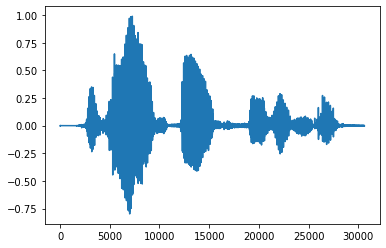

In [2]:
import matplotlib.pyplot as plt

plt.plot(neural_data.audio(0))

In [6]:
from scipy.io.wavfile import write
data = neural_data.audio(0)
write('/scratch/gilbreth/akamsali/Research/Makin/Auditory_Cortex/notebooks/test.wav', 16000, data.astype(np.int16))

NameError: name 'np' is not defined

In [2]:
class TransformerModel:
	
    def __init__(self):
        self.layers = ["model.encoder.conv.conv_layers.0","model.encoder.conv.conv_layers.1","model.encoder.layers.0.fc2",
                        "model.encoder.layers.1.fc2","model.encoder.layers.2.fc2","model.encoder.layers.3.fc2",
                        "model.encoder.layers.4.fc2","model.encoder.layers.5.fc2","model.encoder.layers.6.fc2",
                        "model.encoder.layers.7.fc2","model.encoder.layers.8.fc2","model.encoder.layers.9.fc2"]
        self.model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
        self.processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")
        self.model_extractor = Feature_Extractor_S2T(self.model, self.layers)

In [3]:
dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
subject = '200206'

In [4]:
class GetFeatures:
    def __init__(self, dir, subject, delay=0, model='transformer', VERBOSE=False):
        self.model_name = model
        if self.model_name == 'transformer':
            self.model = TransformerModel()
            self.neural_data = Neural_Data(dir, subject)

            self.get_transformer_features()
            if VERBOSE:
                print("Got transformer features")

            self.get_spikes()
            if VERBOSE:
                print("Got spikes")

    def translate(self, aud, fs = 16000):
        self.inputs_features = self.model.processor(aud,padding=True, sampling_rate=fs, return_tensors="pt").input_features
        generated_ids = self.model.model_extractor(self.inputs_features)

    def get_transformer_features(self):
        features = [{} for _ in range(len(self.model.layers))]
        for i in range(0,499):
            self.translate(self.neural_data.audio(i))

            for j, l in enumerate(self.model.layers):
                features[j][i] = self.model.model_extractor.features[l]

        self.all_hidden_features = features
        

    def get_spikes(self, delay=0):
        spikes = [{}, {}]
        for i in range(1,500):
            spikes[0][i] = self.neural_data.retrieve_spike_counts(sent=i, win=20, delay=delay, 
                                                                early_spikes=False,
                                                                model=self.model_name, 
                                                                offset=-0.25)
            spikes[1][i] = self.neural_data.retrieve_spike_counts(sent=i, win=40, delay=delay, 
                                                                early_spikes=False,
                                                                model=self.model_name,
                                                                offset=0.39)

        self.all_spikes_dict = spikes

In [5]:
get_features = GetFeatures(dir, subject)

here: tensor([[[ -5.6510,   0.1362,   0.2968,  ...,   0.5999,   1.0021,   0.9691],
         [ -1.5049,  -7.5831,  -2.4830,  ...,   0.0267,   4.9148,   9.5986],
         [ -2.5250,  -0.2564,   1.7103,  ...,   0.3897,   1.6792,   4.2316],
         ...,
         [ -4.2596,  -4.7517,  -4.6917,  ...,  -4.3568,  -5.4333,  -1.8696],
         [-13.9477, -18.8889, -18.5072,  ..., -11.4304, -11.7636, -10.2156],
         [  4.8948,  -8.7143,   2.1776,  ...,  -5.3078,  -3.8031,  -9.2630]]])
here: tensor([[[-0.7943, -1.0709, -2.8768,  ...,  3.0357, -2.8083, -3.8901],
         [-1.9396,  0.6881,  0.8633,  ...,  0.6930,  2.6125,  3.8198],
         [ 4.5162,  0.7016,  2.9253,  ...,  1.7086,  3.5383,  3.5124],
         ...,
         [15.8039, 19.5340, 18.9237,  ..., 20.6880, 21.5098, 13.5771],
         [-2.5955, -2.5936, -3.3392,  ..., -2.0630, -1.5028, -1.8669],
         [ 4.3625,  4.0258,  4.6164,  ...,  3.5876,  2.8025, -0.6582]]])
here: tensor([[[ -7.5334,  -6.9351, -18.6909,  ...,  12.2078,  31.11

/home/akamsali/anaconda3/envs/research_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


here: tensor([[[ -5.2934,   0.2717,   0.6676,  ...,   0.2530,   0.5142,  -4.5565],
         [ -3.2280,  -0.7403,  -0.2354,  ...,  -1.0775,  -2.2368,   1.1763],
         [ -1.6582,  -0.0383,   0.8380,  ...,   1.2921,   0.3871,   2.8153],
         ...,
         [ -4.6525,  -4.5347,  -4.4942,  ...,  -5.3987,  -4.0509,  -6.1440],
         [-13.2419, -15.8179, -14.7347,  ..., -11.0153, -12.0696,  -7.1743],
         [  3.2711,  -5.8190,   0.0702,  ...,  -4.9245,  -7.7616,  -3.0724]]])
here: tensor([[[-0.9638, -0.8959,  1.7452,  ..., -4.3696, -2.6384,  0.7283],
         [ 0.0665,  1.7279,  0.6899,  ..., -0.0513,  2.3137,  1.9805],
         [ 2.9378, -1.3241,  1.8566,  ...,  2.2986,  0.7267,  2.0888],
         ...,
         [13.6607, 17.2160, 17.8209,  ..., 17.5990, 18.6907, 14.7724],
         [-2.6889, -2.7440, -0.8656,  ..., -1.1870, -1.2127, -2.5881],
         [ 4.4209,  2.7642,  1.9449,  ...,  3.6868,  2.1167,  0.0329]]])
here: tensor([[[-12.3758,  -3.2975, -16.2648,  ...,   5.7475,  27.59

KeyboardInterrupt: 

In [ ]:
import torch

feats = get_features.all_hidden_features
spikes = get_features.all_spikes_dict